## **TRAIN AUGMENTATION**

In [1]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd

# ============================================================
# PATHS
# ============================================================
INPUT_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"
LABELS_CSV = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels.csv"

OUTPUT_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train"
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUT_LABEL_CSV = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train_augmented_labels.csv"

# ============================================================
# AUGMENTATION FUNCTIONS
# ============================================================
def add_gaussian_noise(signal, noise_level):
    noise = np.random.normal(0, noise_level, size=signal.shape)
    return signal + noise

def amplitude_scaling(signal, scale_range):
    scale = np.random.uniform(*scale_range)
    return signal * scale

def time_shift(signal, max_shift_samples):
    shift = np.random.randint(-max_shift_samples, max_shift_samples)
    if shift == 0:
        return signal
    if shift > 0:
        return np.pad(signal[:-shift], (shift, 0))
    else:
        return np.pad(signal[-shift:], (0, -shift))

# ============================================================
# LOAD LABELS
# ============================================================
labels_df = pd.read_csv(LABELS_CSV)
label_map = dict(zip(labels_df["segment_id"], labels_df["label"]))

augmented_labels = []

# ============================================================
# AUGMENTATION LOOP
# ============================================================
for file in os.listdir(INPUT_DIR):
    if not file.endswith(".mat"):
        continue

    segment_id = file.replace(".mat", "")
    mat_path = os.path.join(INPUT_DIR, file)

    data = sio.loadmat(mat_path)
    ecg = data["ecg"].squeeze().astype(np.float32)
    pcg = data["pcg"].squeeze().astype(np.float32)
    fs = int(data["fs"][0][0])

    label = label_map[segment_id]

    # --------------------------------------------------------
    # Original
    # --------------------------------------------------------
    sio.savemat(
        os.path.join(OUTPUT_DIR, segment_id + "_orig.mat"),
        {"ecg": ecg, "pcg": pcg, "fs": fs}
    )

    augmented_labels.append({
        "segment_id": segment_id + "_orig",
        "label": label
    })

    # --------------------------------------------------------
    # Augmentation 1: Gaussian Noise
    # --------------------------------------------------------
    ecg_n = add_gaussian_noise(ecg, 0.01 * np.std(ecg))
    pcg_n = add_gaussian_noise(pcg, 0.02)

    aug_id = segment_id + "_noise"
    sio.savemat(
        os.path.join(OUTPUT_DIR, aug_id + ".mat"),
        {"ecg": ecg_n, "pcg": pcg_n, "fs": fs}
    )

    augmented_labels.append({"segment_id": aug_id, "label": label})

    # --------------------------------------------------------
    # Augmentation 2: Amplitude Scaling
    # --------------------------------------------------------
    ecg_s = amplitude_scaling(ecg, (0.9, 1.1))
    pcg_s = amplitude_scaling(pcg, (0.85, 1.15))

    aug_id = segment_id + "_scale"
    sio.savemat(
        os.path.join(OUTPUT_DIR, aug_id + ".mat"),
        {"ecg": ecg_s, "pcg": pcg_s, "fs": fs}
    )

    augmented_labels.append({"segment_id": aug_id, "label": label})

    # --------------------------------------------------------
    # Augmentation 3: Noise + Scaling + PCG Time Shift
    # --------------------------------------------------------
    ecg_ns = amplitude_scaling(
        add_gaussian_noise(ecg, 0.01 * np.std(ecg)), (0.9, 1.1)
    )

    pcg_ns = amplitude_scaling(
        add_gaussian_noise(pcg, 0.02), (0.85, 1.15)
    )

    max_shift = int(0.05 * fs)  # 50 ms
    pcg_ns = time_shift(pcg_ns, max_shift)

    aug_id = segment_id + "_mix"
    sio.savemat(
        os.path.join(OUTPUT_DIR, aug_id + ".mat"),
        {"ecg": ecg_ns, "pcg": pcg_ns, "fs": fs}
    )

    augmented_labels.append({"segment_id": aug_id, "label": label})

# ============================================================
# SAVE AUGMENTED LABELS
# ============================================================
aug_df = pd.DataFrame(augmented_labels)
aug_df.to_csv(OUT_LABEL_CSV, index=False)

print(f"✅ Augmentation complete")
print(f"Total augmented samples: {len(aug_df)}")
print(f"Labels saved to: {OUT_LABEL_CSV}")


✅ Augmentation complete
Total augmented samples: 9084
Labels saved to: E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train_augmented_labels.csv


## **VISUALIZATION**

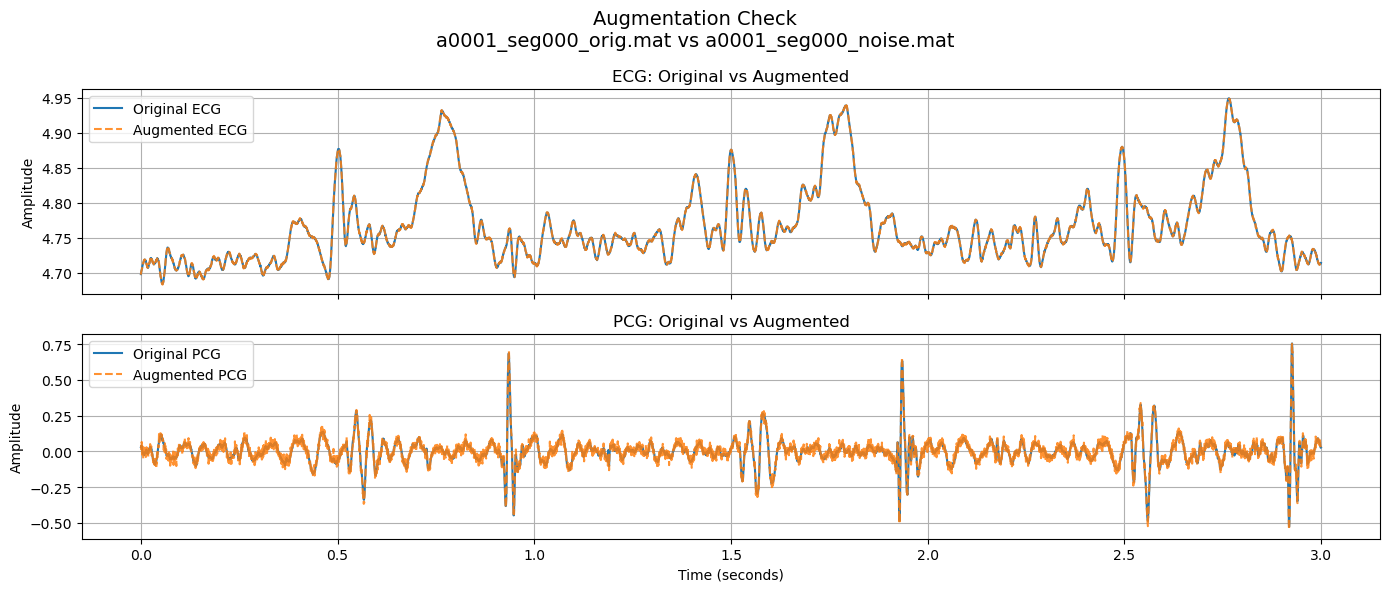

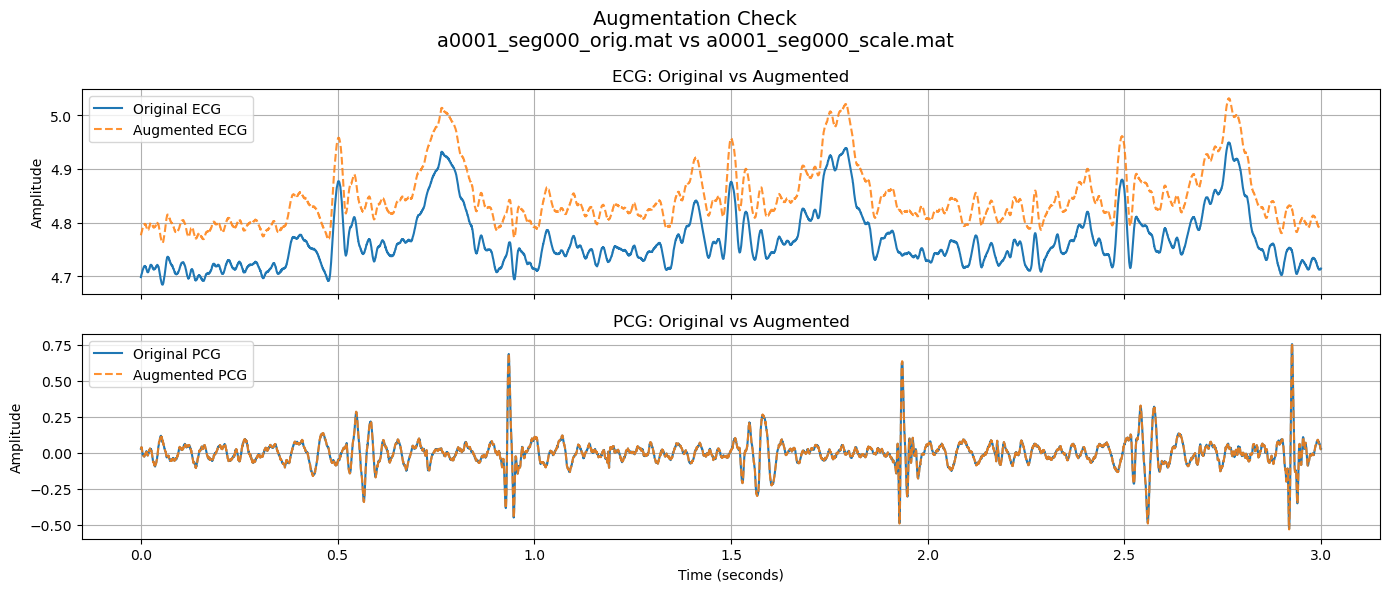

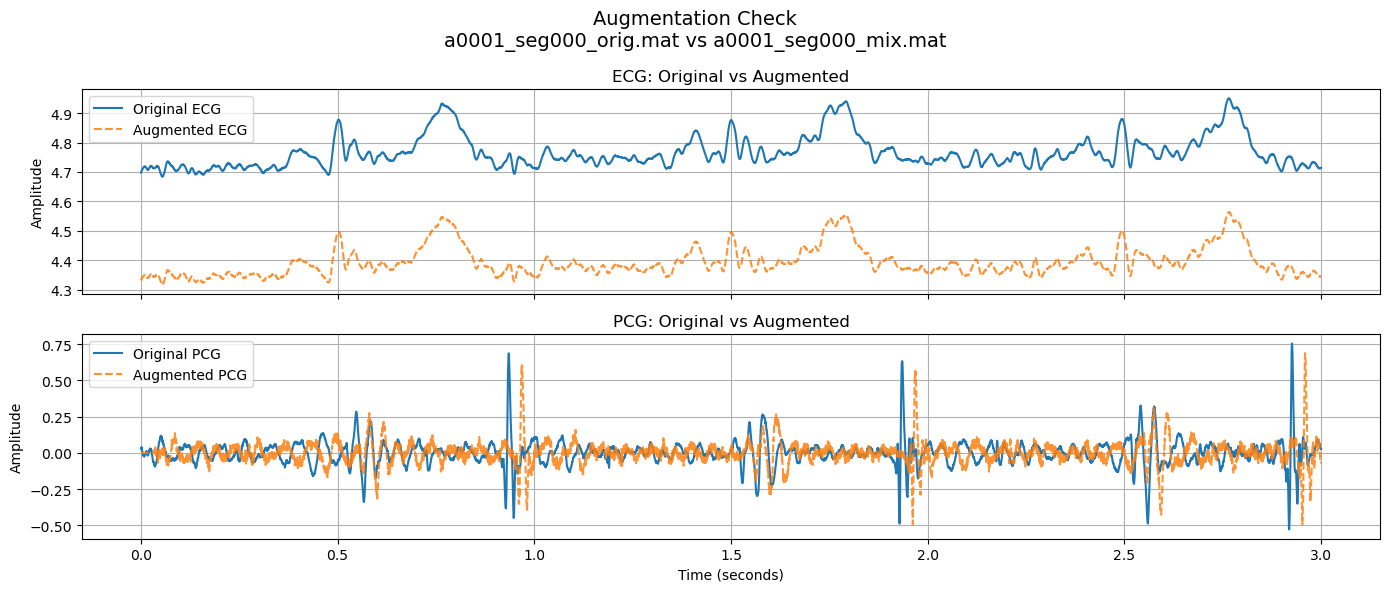

In [6]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_segment(mat_path):
    data = sio.loadmat(mat_path)
    ecg = data['ecg'].squeeze()
    pcg = data['pcg'].squeeze()
    fs  = int(data['fs'].squeeze())
    return ecg, pcg, fs


def visualize_augmentation_pair(orig_path, aug_path):
    ecg_o, pcg_o, fs = load_segment(orig_path)
    ecg_a, pcg_a, _  = load_segment(aug_path)

    t = np.arange(len(ecg_o)) / fs

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # ECG
    axes[0].plot(t, ecg_o, label="Original ECG", linewidth=1.5)
    axes[0].plot(t, ecg_a, label="Augmented ECG", linestyle="--", alpha=0.85)
    axes[0].set_title("ECG: Original vs Augmented")
    axes[0].set_ylabel("Amplitude")
    axes[0].legend()
    axes[0].grid(True)

    # PCG
    axes[1].plot(t, pcg_o, label="Original PCG", linewidth=1.5)
    axes[1].plot(t, pcg_a, label="Augmented PCG", linestyle="--", alpha=0.85)
    axes[1].set_title("PCG: Original vs Augmented")
    axes[1].set_ylabel("Amplitude")
    axes[1].set_xlabel("Time (seconds)")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle(
        f"Augmentation Check\n{Path(orig_path).name} vs {Path(aug_path).name}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

def visualize_all_augmentations(segment_dir, base_name):
    """
    base_name example: 'a0001_seg000'
    """
    segment_dir = Path(segment_dir)

    orig_path = segment_dir / f"{base_name}_orig.mat"
    assert orig_path.exists(), f"Original file not found: {orig_path}"

    aug_types = ["noise", "scale", "mix"]

    for aug in aug_types:
        aug_path = segment_dir / f"{base_name}_{aug}.mat"
        if aug_path.exists():
            visualize_augmentation_pair(orig_path, aug_path)
        else:
            print(f"[WARNING] Missing augmentation: {aug_path.name}")
    
visualize_all_augmentations(
segment_dir=r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train",
base_name="a0001_seg000"
)




### **Interpretation: Original vs Augmented ECG–PCG Segments**

Figure(s) illustrate a comparison between original ECG–PCG segments and their augmented counterparts using three augmentation strategies: additive Gaussian noise, amplitude scaling, and signal mixing.

### Noise Augmentation
The noise-augmented ECG closely overlaps with the original signal, with clear preservation of QRS complexes and overall waveform morphology. The introduced noise is low in amplitude and does not distort key cardiac features. Similarly, the PCG signal exhibits a slight increase in background noise while maintaining distinct heart sound events (S1/S2) and temporal alignment with the ECG. This indicates that noise augmentation introduces realistic variability without compromising physiological integrity.

### Amplitude Scaling
Amplitude-scaled ECG segments retain the original waveform shape, with a uniform change in signal magnitude and no evidence of clipping or polarity inversion. The PCG signal shows consistent temporal structure with proportional amplitude variation. This augmentation effectively simulates inter-subject and sensor-related gain variations while preserving diagnostically relevant information.

### Signal Mixing
Signal mixing produces moderate morphological variation in both ECG and PCG signals while maintaining identifiable cardiac cycles and heart sound patterns. Temporal synchrony between ECG and PCG signals remains intact, and no artificial discontinuities are introduced. This augmentation increases signal diversity while remaining physiologically plausible.

### Overall Assessment
Across all augmentation techniques, the following properties are consistently preserved:
- ECG morphological features, including QRS complexes
- PCG heart sound characteristics and acoustic energy patterns
- Temporal alignment between ECG and PCG signals
- Absence of signal clipping, saturation, or time warping

These observations confirm that the applied augmentation strategies generate realistic variations of the original signals without altering class-defining characteristics, making them suitable for training deep learning models.


### **Checking NAN files**

In [6]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------
DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 9084

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 692
   a0014_seg000_mix.mat
   a0014_seg000_noise.mat
   a0014_seg000_orig.mat
   a0014_seg000_scale.mat
   a0014_seg001_mix.mat
   a0014_seg001_noise.mat
   a0014_seg001_orig.mat
   a0014_seg001_scale.mat
   a0014_seg002_mix.mat
   a0014_seg002_noise.mat
   a0014_seg002_orig.mat
   a0014_seg002_scale.mat
   a0014_seg003_mix.mat
   a0014_seg003_noise.mat
   a0014_seg003_orig.mat
   a0014_seg003_scale.mat
   a0014_seg004_mix.mat
   a0014_seg004_noise.mat
   a0014_seg004_orig.mat
   a0014_seg004_scale.mat
   a0014_seg005_mix.mat
   a0014_seg005_noise.mat
   a0014_seg005_orig.mat
   a0014_seg005_scale.mat
   a0014_seg006_mix.mat
   a0014_seg006_noise.mat
   a0014_seg006_orig.mat
   a0014_seg006_scale.mat
   a0014_seg007_mix.mat
   a0014_seg007_noise.mat
   a0014_seg007_orig.mat
   a0014_seg007_scale.mat
   a0014_seg008_mix.mat
   a0014_seg008_noise.mat
   a0014_seg008_orig.mat
   a0014_seg008_scale.mat
   

### **Removing NAN files**

In [7]:
import os

# ------------------------------------------------
# Augmented train data directory
# ------------------------------------------------
AUG_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train"

# ------------------------------------------------
# Base segment IDs with invalid PCG (NO suffix)
# ------------------------------------------------
invalid_base_segments = [
    "a0014_seg000","a0014_seg001","a0014_seg002","a0014_seg003","a0014_seg004",
    "a0014_seg005","a0014_seg006","a0014_seg007","a0014_seg008","a0014_seg009",

    "a0027_seg000","a0027_seg001","a0027_seg002","a0027_seg003","a0027_seg004",
    "a0027_seg005","a0027_seg006","a0027_seg007","a0027_seg008",

    "a0028_seg000","a0028_seg001","a0028_seg002","a0028_seg003","a0028_seg004",
    "a0028_seg005","a0028_seg006","a0028_seg007","a0028_seg008",

    "a0045_seg000","a0045_seg001","a0045_seg002","a0045_seg003","a0045_seg004",
    "a0045_seg005","a0045_seg006","a0045_seg007","a0045_seg008","a0045_seg009",

    "a0055_seg000","a0055_seg001","a0055_seg002","a0055_seg003","a0055_seg004",
    "a0055_seg005","a0055_seg006","a0055_seg007","a0055_seg008","a0055_seg009",
    "a0055_seg010",

    "a0057_seg000","a0057_seg001","a0057_seg002","a0057_seg003","a0057_seg004",
    "a0057_seg005","a0057_seg006","a0057_seg007","a0057_seg008","a0057_seg009",
    "a0057_seg010",

    "a0068_seg000","a0068_seg001","a0068_seg002","a0068_seg003","a0068_seg004",
    "a0068_seg005","a0068_seg006","a0068_seg007","a0068_seg008","a0068_seg009",
    "a0068_seg010",

    "a0070_seg000","a0070_seg001","a0070_seg002","a0070_seg003","a0070_seg004",
    "a0070_seg005","a0070_seg006","a0070_seg007",

    "a0075_seg000","a0075_seg001","a0075_seg002","a0075_seg003","a0075_seg004",
    "a0075_seg005","a0075_seg006","a0075_seg007","a0075_seg008",

    "a0118_seg000","a0118_seg001","a0118_seg002","a0118_seg003","a0118_seg004",
    "a0118_seg005","a0118_seg006","a0118_seg007","a0118_seg008",

    "a0160_seg000","a0160_seg001","a0160_seg002","a0160_seg003","a0160_seg004",
    "a0160_seg005","a0160_seg006","a0160_seg007","a0160_seg008","a0160_seg009",

    "a0163_seg000","a0163_seg001","a0163_seg002","a0163_seg003","a0163_seg004",
    "a0163_seg005","a0163_seg006","a0163_seg007","a0163_seg008",

    "a0179_seg000","a0179_seg001","a0179_seg002","a0179_seg003","a0179_seg004",
    "a0179_seg005","a0179_seg006","a0179_seg007","a0179_seg008",

    "a0250_seg000","a0250_seg001","a0250_seg002","a0250_seg003","a0250_seg004",
    "a0250_seg005","a0250_seg006","a0250_seg007","a0250_seg008",

    "a0274_seg000","a0274_seg001","a0274_seg002","a0274_seg003","a0274_seg004",
    "a0274_seg005","a0274_seg006","a0274_seg007","a0274_seg008","a0274_seg009",
    "a0274_seg010",

    "a0303_seg000","a0303_seg001","a0303_seg002","a0303_seg003","a0303_seg004",
    "a0303_seg005","a0303_seg006","a0303_seg007","a0303_seg008","a0303_seg009",

    "a0315_seg000","a0315_seg001","a0315_seg002","a0315_seg003","a0315_seg004",
    "a0315_seg005",

    "a0361_seg000","a0361_seg001","a0361_seg002","a0361_seg003","a0361_seg004",
    "a0361_seg005","a0361_seg006","a0361_seg007",

    "a0395_seg000","a0395_seg001","a0395_seg002","a0395_seg003"
]

# ------------------------------------------------
# Remove augmented files
# ------------------------------------------------
removed = 0

for file in os.listdir(AUG_DIR):
    if not file.endswith(".mat"):
        continue

    base_id = file.replace("_orig.mat","") \
                  .replace("_noise.mat","") \
                  .replace("_scale.mat","") \
                  .replace("_mix.mat","")

    if base_id in invalid_base_segments:
        os.remove(os.path.join(AUG_DIR, file))
        removed += 1
        print(f"Removed: {file}")

print(f"\n✅ Total augmented files removed: {removed}")


Removed: a0014_seg000_mix.mat
Removed: a0014_seg000_noise.mat
Removed: a0014_seg000_orig.mat
Removed: a0014_seg000_scale.mat
Removed: a0014_seg001_mix.mat
Removed: a0014_seg001_noise.mat
Removed: a0014_seg001_orig.mat
Removed: a0014_seg001_scale.mat
Removed: a0014_seg002_mix.mat
Removed: a0014_seg002_noise.mat
Removed: a0014_seg002_orig.mat
Removed: a0014_seg002_scale.mat
Removed: a0014_seg003_mix.mat
Removed: a0014_seg003_noise.mat
Removed: a0014_seg003_orig.mat
Removed: a0014_seg003_scale.mat
Removed: a0014_seg004_mix.mat
Removed: a0014_seg004_noise.mat
Removed: a0014_seg004_orig.mat
Removed: a0014_seg004_scale.mat
Removed: a0014_seg005_mix.mat
Removed: a0014_seg005_noise.mat
Removed: a0014_seg005_orig.mat
Removed: a0014_seg005_scale.mat
Removed: a0014_seg006_mix.mat
Removed: a0014_seg006_noise.mat
Removed: a0014_seg006_orig.mat
Removed: a0014_seg006_scale.mat
Removed: a0014_seg007_mix.mat
Removed: a0014_seg007_noise.mat
Removed: a0014_seg007_orig.mat
Removed: a0014_seg007_scale.mat


### **Verifying Removal**

In [8]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------

DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 8392

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 0

Both ECG & PCG invalid: 0


### **Removing Labels**

In [9]:
import pandas as pd

# ------------------------------------------------
# Paths
# ------------------------------------------------
LABEL_CSV = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train_augmented_labels.csv"
OUT_CSV   = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train_augmented_labels_cleaned.csv"

# ------------------------------------------------
# Base segment IDs with invalid PCG (NO augmentation suffix)
# ------------------------------------------------
invalid_base_segments = [
    "a0014_seg000","a0014_seg001","a0014_seg002","a0014_seg003","a0014_seg004",
    "a0014_seg005","a0014_seg006","a0014_seg007","a0014_seg008","a0014_seg009",

    "a0027_seg000","a0027_seg001","a0027_seg002","a0027_seg003","a0027_seg004",
    "a0027_seg005","a0027_seg006","a0027_seg007","a0027_seg008",

    "a0028_seg000","a0028_seg001","a0028_seg002","a0028_seg003","a0028_seg004",
    "a0028_seg005","a0028_seg006","a0028_seg007","a0028_seg008",

    "a0045_seg000","a0045_seg001","a0045_seg002","a0045_seg003","a0045_seg004",
    "a0045_seg005","a0045_seg006","a0045_seg007","a0045_seg008","a0045_seg009",

    "a0055_seg000","a0055_seg001","a0055_seg002","a0055_seg003","a0055_seg004",
    "a0055_seg005","a0055_seg006","a0055_seg007","a0055_seg008","a0055_seg009",
    "a0055_seg010",

    "a0057_seg000","a0057_seg001","a0057_seg002","a0057_seg003","a0057_seg004",
    "a0057_seg005","a0057_seg006","a0057_seg007","a0057_seg008","a0057_seg009",
    "a0057_seg010",

    "a0068_seg000","a0068_seg001","a0068_seg002","a0068_seg003","a0068_seg004",
    "a0068_seg005","a0068_seg006","a0068_seg007","a0068_seg008","a0068_seg009",
    "a0068_seg010",

    "a0070_seg000","a0070_seg001","a0070_seg002","a0070_seg003","a0070_seg004",
    "a0070_seg005","a0070_seg006","a0070_seg007",

    "a0075_seg000","a0075_seg001","a0075_seg002","a0075_seg003","a0075_seg004",
    "a0075_seg005","a0075_seg006","a0075_seg007","a0075_seg008",

    "a0118_seg000","a0118_seg001","a0118_seg002","a0118_seg003","a0118_seg004",
    "a0118_seg005","a0118_seg006","a0118_seg007","a0118_seg008",

    "a0160_seg000","a0160_seg001","a0160_seg002","a0160_seg003","a0160_seg004",
    "a0160_seg005","a0160_seg006","a0160_seg007","a0160_seg008","a0160_seg009",

    "a0163_seg000","a0163_seg001","a0163_seg002","a0163_seg003","a0163_seg004",
    "a0163_seg005","a0163_seg006","a0163_seg007","a0163_seg008",

    "a0179_seg000","a0179_seg001","a0179_seg002","a0179_seg003","a0179_seg004",
    "a0179_seg005","a0179_seg006","a0179_seg007","a0179_seg008",

    "a0250_seg000","a0250_seg001","a0250_seg002","a0250_seg003","a0250_seg004",
    "a0250_seg005","a0250_seg006","a0250_seg007","a0250_seg008",

    "a0274_seg000","a0274_seg001","a0274_seg002","a0274_seg003","a0274_seg004",
    "a0274_seg005","a0274_seg006","a0274_seg007","a0274_seg008","a0274_seg009",
    "a0274_seg010",

    "a0303_seg000","a0303_seg001","a0303_seg002","a0303_seg003","a0303_seg004",
    "a0303_seg005","a0303_seg006","a0303_seg007","a0303_seg008","a0303_seg009",

    "a0315_seg000","a0315_seg001","a0315_seg002","a0315_seg003","a0315_seg004",
    "a0315_seg005",

    "a0361_seg000","a0361_seg001","a0361_seg002","a0361_seg003","a0361_seg004",
    "a0361_seg005","a0361_seg006","a0361_seg007",

    "a0395_seg000","a0395_seg001","a0395_seg002","a0395_seg003"
]

# ------------------------------------------------
# Load labels
# ------------------------------------------------
df = pd.read_csv(LABEL_CSV)

before = len(df)

# Remove rows where segment_id starts with any invalid base segment
df_clean = df[
    ~df["segment_id"].apply(
        lambda x: any(x.startswith(base) for base in invalid_base_segments)
    )
]

after = len(df_clean)

# ------------------------------------------------
# Save cleaned labels
# ------------------------------------------------
df_clean.to_csv(OUT_CSV, index=False)

print(f"Original augmented labels: {before}")
print(f"Removed invalid augmented labels: {before - after}")
print(f"Clean labels saved: {after}")
print(f"Saved to: {OUT_CSV}")


Original augmented labels: 9084
Removed invalid augmented labels: 692
Clean labels saved: 8392
Saved to: E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\5-AUGMENTED_DATA\train_augmented_labels_cleaned.csv
